In [90]:
#use conv net to train a vision transformer on CIFAR-10

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np

import matplotlib.pyplot as plt

device = torch.device('xpu')

In [4]:
def get_teacher_model(device):
  '''
  get resnet18 teacher model from timm, with pretrained weights
  '''
  import timm
  resnet18 = timm.create_model("resnet18_cifar10", pretrained=True)
  #don't want to accidentally update params during training
  for p in resnet18.parameters():
    p.requires_grad = False
  resnet18.to(device)
  return resnet18

get_teacher_model(torch.device('cpu'))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_

In [1]:
import detectors
import timm

resnet18 = timm.create_model("resnet18_cifar10", pretrained=True)
#don't want to do any retraining on teacher model
for p in resnet18.parameters():
  p.requires_grad = False
resnet18.to(device)
print('model running on ', next(resnet18.parameters()).device)
print(f'number of parameters: {sum([p.numel() for p in resnet18.parameters()]):,}', )

/home/jacob/Desktop/programming/learning/ml/cv_selflearning/.venv/lib/python3.12/site-packages/outdated/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
/home/jacob/Desktop/programming/learning/ml/cv_selflearning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'device' is not defined

In [5]:
def get_student_model():
  """Create ViT model for CIFAR-10"""
  model = timm.create_model('vit_tiny_patch16_224', pretrained=False, num_classes=10)
  #model.to(device)
  return model

student_model = get_student_model()

In [6]:
student_model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [133]:
#create dataset with pytorch datset and dataloaders
transform = torchvision.transforms.ToTensor()
TRAIN_BATCH_SIZE = 128

trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform,
)
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, 
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform,
)
testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=200,
    shuffle=False, 
    num_workers=2
)

In [94]:
#create class map: index to output class name
class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

Text(0.5, 1.0, 'truck')

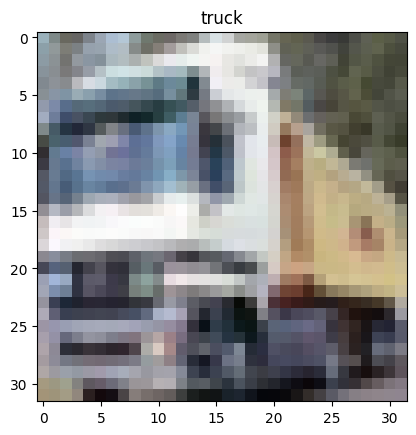

In [95]:
idx = 1
img, label = trainset.__getitem__(idx)
plt.imshow(img.transpose(0, 2).transpose(0, 1))
plt.title(class_names[label])

In [96]:
#accuracy of classification
def eval_model(model, testloader, device):
  acc_list = []
  denom = 0
  for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    out = model(inputs)
    preds = out.argmax(dim=-1)
    acc = preds.eq(labels).sum()
    denom += inputs.shape[0]
    acc_list.append(acc)
  return sum(acc_list) / denom

In [130]:
#show accuracy of timm resnet18 model

eval_model(resnet18, testloader, device)

tensor(0.9323, device='xpu:0')

### Initialize ViT model

In [97]:
class MLP(nn.Module):
    def __init__(self, embed_dim, dropout, upsample_ratio=4):
        super().__init__()
        self.nn = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim*upsample_ratio),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(embed_dim*upsample_ratio, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, X):
        return self.nn(X)

In [98]:
class MSA(nn.Module):
  def __init__(self, embed_dim, num_heads, dropout, use_mask):
    super().__init__()
    self.ln = nn.LayerNorm(embed_dim)
    self.num_heads = num_heads
    self.d_k = embed_dim // num_heads
    self.Wq = nn.Linear(embed_dim, embed_dim)
    self.Wk = nn.Linear(embed_dim, embed_dim)
    self.Wv = nn.Linear(embed_dim, embed_dim)
    self.msa = nn.MultiheadAttention(
      embed_dim=embed_dim,
      num_heads=num_heads,
      dropout=dropout,
      batch_first=True
    )
    self.use_mask = use_mask

  def forward(self, X):
    X_ln = self.ln(X)
    batch_size, seq_len = X.shape[0], X.shape[1]
    Q = self.Wq(X_ln)
    K = self.Wk(X_ln)
    V = self.Wv(X_ln)
    if self.use_mask:
      mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=-1)
      if next(self.Wq.parameters()).device.type == 'xpu':
        mask = mask.to(device)      
      X_msa = self.msa(Q, K, V, attn_mask=mask)
    else:
      X_msa = self.msa(Q, K, V)
    return X_msa

In [99]:
class AttentionBlock(nn.Module):
  def __init__(self, embed_dim, num_heads, dropout, use_mask):
    super().__init__()
    self.msa = MSA(
      embed_dim=embed_dim, 
      num_heads=num_heads, 
      dropout=dropout, 
      use_mask=use_mask
    )
    self.mlp = MLP(
      embed_dim=embed_dim,
      dropout=dropout,
    )
  
  def forward(self, X):
    X_msa, msa_weights = self.msa(X)
    X = X + X_msa
    X_mlp = self.mlp(X)
    X = X + X_mlp
    return X

In [100]:
class Embeddings(nn.Module):
  def __init__(self, embed_dim, unfolded_patch_dim, max_seq_len):
    super().__init__()
    self.embed_dim = embed_dim
    self.max_seq_len = max_seq_len
    self.x_class = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)
    self.embedding = nn.Linear(in_features=unfolded_patch_dim, out_features=embed_dim, bias=False)
    self.pos_embedding = nn.Embedding(num_embeddings=max_seq_len, embedding_dim=embed_dim)

  def forward(self, X):
    batch_size, seq_len = X.shape[0], X.shape[1] + 1
    X_e = self.embedding(X)
    x_class_e = self.x_class.expand(batch_size, 1, self.embed_dim)
    X_e = torch.concat(
      [x_class_e, X_e],
      dim=1
    )
    seq = torch.arange(seq_len)
    if next(self.pos_embedding.parameters()).device.type == 'xpu':
      seq = seq.to(device)
    X_pe = self.pos_embedding(seq).unsqueeze(0)
    return X_e + X_pe

In [107]:
#img_hw is tuple of (height, width), and so is patch_size
class ViT(nn.Module):
  def __init__(self, embed_dim, num_classes, patch_size, img_hw, num_heads, dropout=0.0, use_mask=True):
    super().__init__()
    self.patch_size = patch_size
    self.n = (img_hw[0] * img_hw[1]) // (self.patch_size ** 2)
    self.unfolded_patch_dim = self.patch_size ** 2 * 3 #patch size num of pixels * 3 color channels
    self.embeddings = Embeddings(
      embed_dim=embed_dim, 
      unfolded_patch_dim=self.unfolded_patch_dim, 
      max_seq_len=self.n + 1
    )
    self.attention_blocks = nn.Sequential(
      AttentionBlock(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, use_mask=use_mask),
      AttentionBlock(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, use_mask=use_mask),
      AttentionBlock(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, use_mask=use_mask),
      AttentionBlock(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, use_mask=use_mask),
      AttentionBlock(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, use_mask=use_mask),
      AttentionBlock(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, use_mask=use_mask),
      AttentionBlock(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, use_mask=use_mask),
      AttentionBlock(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, use_mask=use_mask),
    )
    self.ln = nn.LayerNorm(embed_dim)
    self.ll_out = nn.Linear(embed_dim, num_classes)

  def forward(self, X):
    X = F.unfold(
      X, 
      kernel_size=self.patch_size, 
      stride=self.patch_size)\
      .transpose(-1, -2) #unfold img into patches
    X = self.embeddings(X)
    X = self.attention_blocks(X)
    x_class = X[:, 0, :]
    out = self.ll_out(self.ln(x_class))
    return out

### Train ViT using normal approach

In [119]:
vit_normal = ViT(
  embed_dim=128,
  num_classes=10,
  patch_size=4,
  img_hw=(32, 32),
  num_heads=8,
  dropout=0.2,
)
vit_normal.to(device)

print(f'number of params: {sum([p.numel() for p in vit_normal.parameters()]):,}')

number of params: 1,998,602


In [122]:
#optim_vit_normal = optim.SGD(params=vit_normal.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
optim_vit_normal = optim.Adam(params=vit_normal.parameters(), lr=0.002, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

In [123]:
for epoch in range(5):
  vit_normal.train()
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = vit_normal(inputs)
    optim_vit_normal.zero_grad()
    loss = criterion(outputs, labels)
    loss.backward()
    optim_vit_normal.step()

    if i % 200 == 99:
      print(f'epoch {epoch}, batch {i}: loss = {loss.item()}')

  #eval model at end of epoch
  vit_normal.eval()
  acc = eval_model(vit_normal, testloader, device).item()
  print('test accuracy: ', acc, '\n')

epoch 0, batch 99: loss = 1.2524027824401855
epoch 0, batch 299: loss = 1.3289605379104614
test accuracy:  0.527899980545044 

epoch 1, batch 99: loss = 1.2240197658538818
epoch 1, batch 299: loss = 1.3136392831802368
test accuracy:  0.5375999808311462 

epoch 2, batch 99: loss = 1.2499678134918213
epoch 2, batch 299: loss = 1.2821192741394043
test accuracy:  0.5406999588012695 

epoch 3, batch 99: loss = 1.2933807373046875
epoch 3, batch 299: loss = 1.3026978969573975
test accuracy:  0.49609997868537903 

epoch 4, batch 99: loss = 1.3581798076629639
epoch 4, batch 299: loss = 1.2873262166976929
test accuracy:  0.5227999687194824 



In [118]:
import datetime
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
torch.save(vit_normal.state_dict(), f'./data/vit_normal_{ts}.pt')

### Train ViT model using Student-Teacher with resnet

In [177]:
#generate new "soft" trainset and dataloader with soft labels

train_imgs = []
soft_labels = []
resnet18.eval()
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    outputs = resnet18(inputs)
    soft_label = F.softmax(outputs, dim=-1)
    
    train_imgs.append(inputs.cpu())
    soft_labels.append(soft_label.cpu())

soft_trainset = torch.utils.data.TensorDataset(
  torch.cat(train_imgs, dim=0),
  torch.cat(soft_labels, dim=0),
)
soft_trainloader = torch.utils.data.DataLoader(
  soft_trainset,
  batch_size=TRAIN_BATCH_SIZE,
  shuffle=True, 
  num_workers=2,
)

print('original dataset size: ', len(trainset))
print('new dataset size: ', len(soft_trainset))


original dataset size:  50000
new dataset size:  50000


In [22]:
from torch.utils.data import DataLoader, Dataset, ConcatDataset

class MultiLabelDataset(Dataset):
  def __init__(self, data, labels1, labels2, transform=None):
    if len(data) != len(labels1) or len(data) != len(labels2):
      raise ValueError("All input lists must have the same length.")

    self.data = data
    self.labels1 = labels1
    self.labels2 = labels2
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample = self.data[idx]
    label1 = self.labels1[idx]
    label2 = self.labels2[idx]

    if self.transform:
      sample = self.transform(sample)

    return sample, label1, label2

def get_soft_data(teacher, trainloader, batch_size, device):
  datasets = []
  imgs, hard_labels, soft_labels = [], [], []
  teacher.eval()
  with torch.no_grad():
    for i, data in enumerate(trainloader, 0):
      print(i)
      inputs, labels = data
      inputs = inputs.to(device)
      outputs = teacher(inputs)
      imgs.append(inputs.cpu())
      hard_labels.append(labels)
      soft_labels.append(outputs.cpu())

  soft_trainset = MultiLabelDataset(
    torch.concat(imgs, dim=0),
    torch.concat(hard_labels, dim=0),
    torch.concat(soft_labels, dim=0),
  )
  soft_trainloader = torch.utils.data.DataLoader(
    soft_trainset,
    batch_size=batch_size,
    shuffle=True, 
    num_workers=2,
  )
  return soft_trainset, soft_trainloader

In [23]:
teacher_model = get_teacher_model(device)

In [24]:
from load_cifar import get_cifar10_data
trainset, testset, trainloader, testloader = get_cifar10_data(128)

In [ ]:
soft_trainset, soft_trainloader = get_soft_data(teacher_model, trainloader, 128, device)
torch.save(soft_trainset, 'soft_trainset.pt')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101


In [6]:
from load_cifar import MultiLabelDataset
l_soft_ts = torch.load('soft_trainset.pt', weights_only=False)

/home/jacob/Desktop/programming/learning/ml/cv_selflearning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jacob/Desktop/programming/learning/ml/cv_selflearning/.venv/lib/python3.12/site-packages/outdated/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [178]:
#test that distributions were created properly 
data, dist = soft_trainset.__getitem__(0)
data = data.to(device)
out_test = resnet18(data.unsqueeze(0)).cpu()
out_test = F.softmax(out_test, dim=-1)
dist.allclose(out_test)

True

In [179]:
vit_student = ViT(
  embed_dim=128,
  num_classes=10,
  patch_size=4,
  img_hw=(32, 32),
  num_heads=8,
  dropout=0.2,
)
vit_student.to(device)

print(f'number of params: {sum([p.numel() for p in vit_normal.parameters()]):,}')

number of params: 1,998,602


In [191]:
optim_vit_student = optim.Adam(params=vit_student.parameters(), lr=0.0001, weight_decay=0.001)
student_criterion = nn.KLDivLoss()

In [192]:
for epoch in range(20):
  resnet18.eval()
  vit_student.train()
  for i, data in enumerate(soft_trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = vit_student(inputs)
    outputs = F.log_softmax(outputs, dim=-1) #convert to log probabilities

    optim_vit_student.zero_grad()
    loss = F.kl_div(outputs, labels, reduction='batchmean')
    #loss = student_criterion(outputs, labels)
    loss.backward()
    optim_vit_student.step()

    if i % 200 == 99:
      print(f'epoch {epoch}, batch {i}: loss = {loss.item()}')

  #eval model at end of epoch
  vit_student.eval()
  acc = eval_model(vit_student, testloader, device).item()
  print('test accuracy: ', acc, '\n')

epoch 0, batch 99: loss = 1.231581211090088
epoch 0, batch 299: loss = 1.2767869234085083
test accuracy:  0.257099986076355 

epoch 1, batch 99: loss = 1.1059911251068115
epoch 1, batch 299: loss = 1.174439787864685
test accuracy:  0.24859999120235443 

epoch 2, batch 99: loss = 1.3394922018051147
epoch 2, batch 299: loss = 1.3345446586608887
test accuracy:  0.2581999897956848 

epoch 3, batch 99: loss = 1.2181655168533325
epoch 3, batch 299: loss = 1.265332579612732
test accuracy:  0.25519999861717224 

epoch 4, batch 99: loss = 1.2227413654327393
epoch 4, batch 299: loss = 1.2456021308898926
test accuracy:  0.2563999891281128 

epoch 5, batch 99: loss = 1.2425376176834106
epoch 5, batch 299: loss = 1.1861951351165771
test accuracy:  0.25529998540878296 

epoch 6, batch 99: loss = 1.2538995742797852
epoch 6, batch 299: loss = 1.3248958587646484
test accuracy:  0.25439998507499695 

epoch 7, batch 99: loss = 1.2701690196990967
epoch 7, batch 299: loss = 1.3446366786956787
test accuracy

### Testing TIMM ViT model

In [3]:
timm_vit = timm.create_model('vit_tiny_patch16_224', pretrained=False, num_classes=10)

In [5]:
sum([p.numel() for p in timm_vit.parameters()])

5526346

In [6]:
timm_vit

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
